In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.test_markov import *
from config import *
from train import *
import figures.plot as plot
from figures.ood_plots import *
from util import *
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange
import os
import re

from figures.head_view import *

torch.set_printoptions(precision=3, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [4]:
# For comments, see TriggerMorkov.ipynb
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, 
            total_trans, alpha, pos_enc="rotary", hidden_dim=128,
            mlp_layers=None, epochs=10000, num_layers=2, show=False):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layers is None:
        mlp_layers = [i for i in range(num_layers)]
        
    mlp = [False] * num_layers
    for i in mlp_layers:
        mlp[i] = True 
    mlp = tuple(mlp)
    
    config = Config(
            emb_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=500,
            get_checkpoints=200,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=hidden_dim,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="latent"
        )

    sampler_config = LatentMarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, total_trans=total_trans, alpha=alpha,
                                               batch_size=BATCH_SIZE, task_name="latent")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=show)

    return train_results, model

In [ ]:
# For comments, see TriggerMorkov.ipynb
def run_exp_icl(SEQ_LEN, VOC_SIZE, BATCH_SIZE, alpha, pos_enc="rotary", hidden_dim=128,
                mlp_layers=None, epochs=10000, num_layers=2, show=False):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layers is None:
        mlp_layers = [i for i in range(num_layers)]
        
    mlp = [False] * num_layers
    for i in mlp_layers:
        mlp[i] = True 
    mlp = tuple(mlp)
    
    config = Config(
            emb_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=500,
            get_checkpoints=200,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=hidden_dim,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="icl-mc"
        )

    sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, order=1, alpha=alpha,
                                         batch_size=BATCH_SIZE, task_name="icl-mc")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=show)

    return train_results, model

In [ ]:
SEQ_LEN, VOC_SIZE, BATCH_SIZE = 128, 5, 64
alpha = 1

for L in range(1, 50):
    total_trans = 5*L
    if total_trans > 20:
        total_trans = 30*L
    print("Total number of transitions: ", total_trans)
    train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", mlp_layers=[1], epochs=15000, num_layers=2)

Total number of transitions:  5


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  10


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  15


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  20


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  150


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  180


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  210


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  240


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  270


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  300


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  330


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  360


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  390


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  420


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  450


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  480


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  510


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  540


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  570


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  600


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  630


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  660


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  690


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  720


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  750


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  780


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  810


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  840


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  870


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  900


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  990


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1110


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1140


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1170


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1200


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1230


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1260


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1290


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1320


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1350


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1380


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1410


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Creating images:   0%|          | 0/16 [00:00<?, ?it/s]

Total number of transitions:  1440


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

### OOD Generalization

In [88]:
path = "checkpoints/latent/MLP1/"
alphas = [0.1, 0.6, 1] 
id_results, ood_results, check_results = get_ood_id(path, alphas)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [165]:
np.save(f"{path}id_results.npy", id_results)
np.save(f"{path}ood_results.npy", ood_results)
with open(f"{path}check_results.pkl", "wb") as f:
    pickle.dump(check_results, f)

In [ ]:
train_results_icl, model_icl = run_exp_icl(SEQ_LEN, VOC_SIZE, BATCH_SIZE, alpha, pos_enc="rotary", mlp_layers=[1], epochs=15000, num_layers=2)

In [163]:
path = "checkpoints/icl-mc/20250301_0039/"
alphas = [0.1, 0.6, 1]
id_results_icl, ood_results_icl, check_results_icl = get_ood_id_icl(path, alphas)

  0%|          | 0/75 [00:00<?, ?it/s]

alpha:  0.1
Unigram Losses Mean: 0.884
Bigram Losses Mean: 0.379
alpha:  0.6
Unigram Losses Mean: 1.445
Bigram Losses Mean: 1.072
alpha:  1
Unigram Losses Mean: 1.509
Bigram Losses Mean: 1.230


Unigram Losses Mean: 1.508
Bigram Losses Mean: 1.232
Unigram Losses Mean: 0.908
Bigram Losses Mean: 0.387


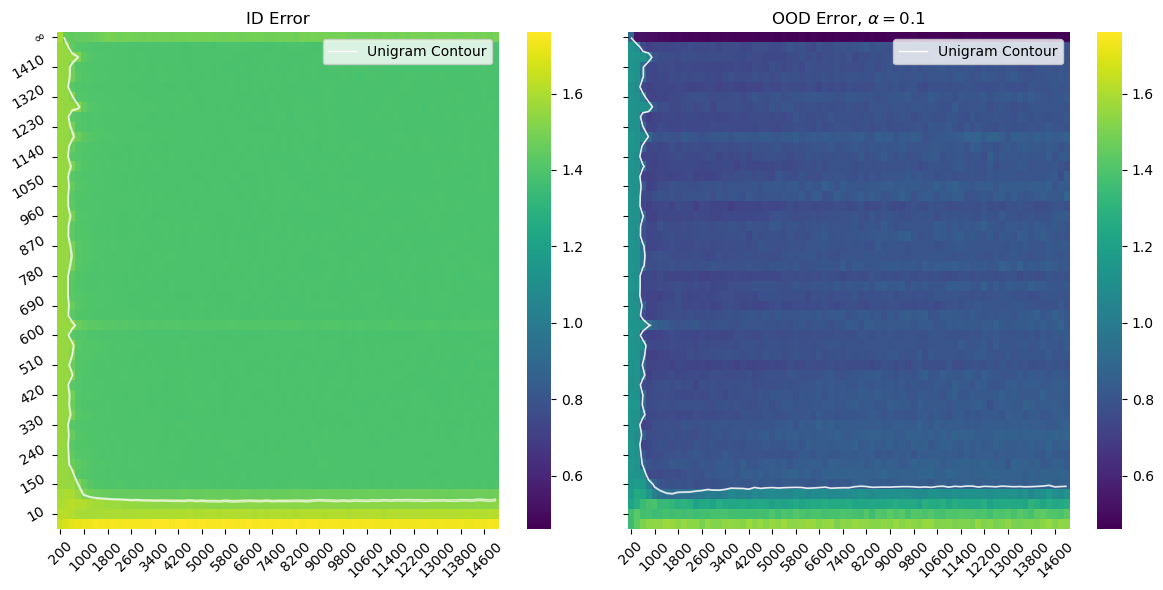

In [171]:
ood_id_plot(0.1, "checkpoints/latent/MLP1/", id_results_icl, ood_results_icl, id_results, ood_results, check_results)

Unigram Losses Mean: 1.508
Bigram Losses Mean: 1.232
Unigram Losses Mean: 0.896
Bigram Losses Mean: 0.386


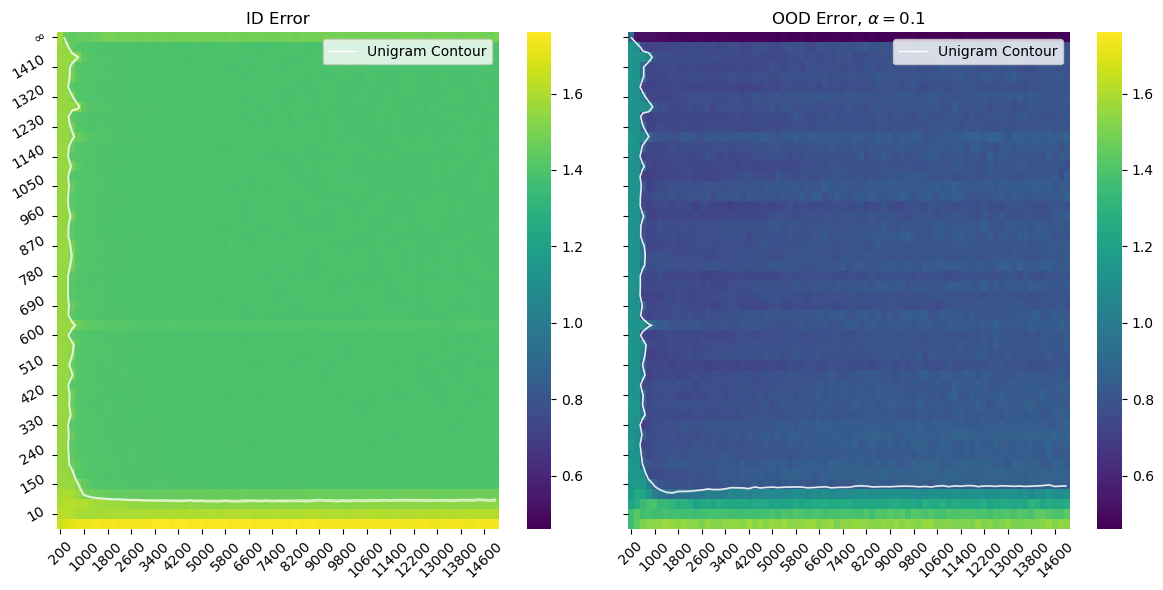

In [172]:
ood_id_plot(0.6, "checkpoints/latent/MLP1/")

### Interpreting small latent markov

Let us try to understand what transformer is doing for small number of hidden latent variables. Consider 2 Markov chains, the transformer will focus on small features, such as the presence of $(2,4)$ if $(2,4)$ has very different occuring probabilities. 

Let us start with interpreting the behaviour of 1. For the first layer, 1 would attend to its own, so we have
$$
\bar{x}_t \approx x_t + W_{OV}^{(1)} x_t.
$$
For the second layer, 1 would mostly attend to 4. In the first layer, 4 has a previous token head if the previous one is not 1. So for 4, we have
$$
\bar{x}_t \approx x_t + \frac{1}{2} W_{OV}^{(1)} x_t + \frac{1}{2} W_{OV}^{(1)} x_{t-1}
$$
$$
\tilde{x}_t \approx \bar{x}_t + \sum_{s} \alpha_s W_{OV}^{(2)} \bar{x}_{s} = x_t + W_{OV}^{(1)} x_t + \text{How many (2,4) occurs}
$$

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sampler = train_results["sampler"]
OV1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
OV2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T
range_toks = model.embed(torch.arange(VOC_SIZE, device=device))
static_info = range_toks + range_toks @ (OV1 + OV2 + OV1@OV2)

In [15]:
batch = sampler.test()[0]
toks = model.embed(batch)
toks = model.layers[0](toks, False)[0]
tok = model.embed(torch.tensor([1]))
(toks[batch == 1] - tok - tok @ OV1).norm(dim=-1)

Latent variable:  0


tensor([0.050, 0.642, 0.693, 1.315, 1.047, 0.670, 0.650, 0.715, 0.952, 0.752,
        0.631, 0.489, 0.547, 0.779, 1.700, 1.571, 1.210, 1.250, 1.405, 1.031],
       grad_fn=<LinalgVectorNormBackward0>)

In [160]:
mlp_out = model.layers[1].mlp(static)
probs = nn.Softmax(dim=-1)(model.output_layer(static + mlp_out))
probs

tensor([[0.083, 0.306, 0.425, 0.046, 0.139],
        [0.158, 0.245, 0.345, 0.186, 0.066],
        [0.121, 0.327, 0.260, 0.185, 0.107],
        [0.263, 0.069, 0.283, 0.304, 0.082],
        [0.043, 0.179, 0.354, 0.141, 0.282]], grad_fn=<SoftmaxBackward0>)

Latent variable:  0


<Axes: >

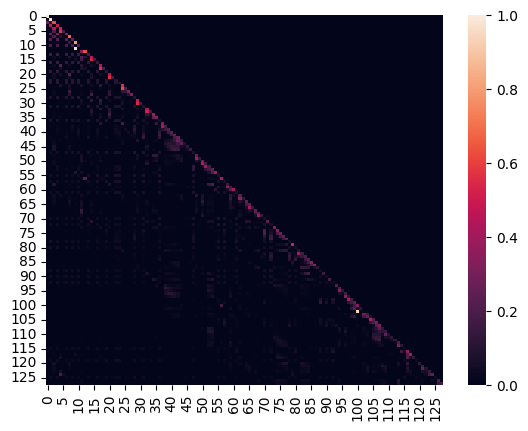

In [19]:
probe, _ = sampler.test(latent=0)
attn0 = get_attn(probe, layer = 0)
sns.heatmap(attn0.detach().numpy().squeeze(0).squeeze(0))
plt.show()

<Axes: >

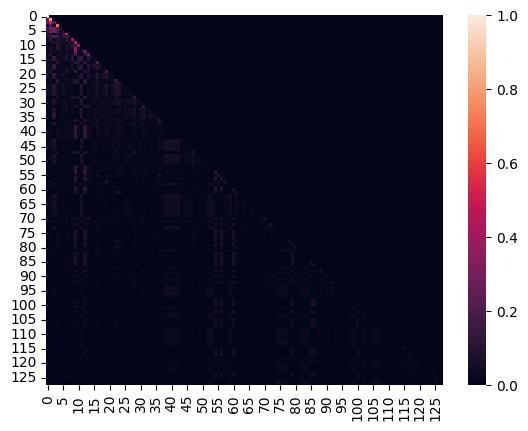

In [20]:
attn1 = get_attn(probe, layer = 1)
sns.heatmap(attn1.detach().numpy().squeeze(0).squeeze(0))
plt.show()

<Axes: >

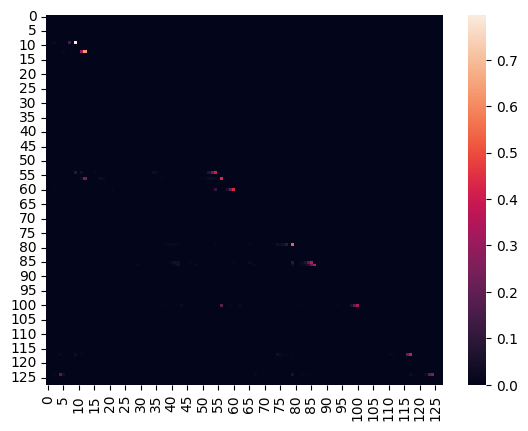

In [24]:
mask = (probe[0]!=4).unsqueeze(1).repeat(1,128)
sns.heatmap(attn0[0][0].masked_fill(mask, 0).detach().numpy())

In [246]:
get_head_view(model, train_results, train_results["config"], trunc=0, action='view', batch=probe_tensor)

<IPython.core.display.Javascript object>

In [234]:
tok = 3
F.kl_div(sampler.trans_matrix[1][tok].log(), nn.Softmax(dim=-1)(model(probe_tensor)[0])[probe==tok], reduction="none").sum(dim=-1)

tensor([    0.001,     0.000,     0.000,     0.000,     0.062,     0.047,
            0.036,     0.075,     0.149,     0.158,     0.161,     0.156,
            0.107,     0.200,     0.170,     0.177,     0.190,     0.190,
            0.189,     0.222,     0.222,     0.223,     0.238,     0.248,
            0.249,     0.249,     0.248,     0.234,     0.235,     0.224],
       grad_fn=<SumBackward1>)

In [48]:
F.cosine_similarity(context0.unsqueeze(1), context0.unsqueeze(0), dim=-1)

tensor([[ 1.000, -0.838, -0.647,  0.783, -0.872],
        [-0.838,  1.000,  0.893, -0.888,  0.989],
        [-0.647,  0.893,  1.000, -0.907,  0.884],
        [ 0.783, -0.888, -0.907,  1.000, -0.882],
        [-0.872,  0.989,  0.884, -0.882,  1.000]], grad_fn=<SumBackward1>)

In [54]:
mlp_out = model.layers[1].mlp(static_info)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + mlp_out)).mean(dim=0)
target = (sampler.trans_matrix[0] + sampler.trans_matrix[1]) / 2
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.110, 0.053, 0.046, 0.214, 0.111], grad_fn=<SumBackward1>)

In [178]:
probs = nn.Softmax(dim=-1)(model.output_layer(static + context0_avg + model.layers[1].mlp(static + context0_avg)))
target = sampler.trans_matrix[0]
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.017, 0.041, 0.005, 0.007, 0.136], grad_fn=<SumBackward1>)

In [176]:
mlp_out = model.layers[1].mlp(static + context1_avg)
probs = nn.Softmax(dim=-1)(model.output_layer(static + context1_avg + mlp_out))
target = sampler.trans_matrix[1]
F.kl_div(target.log(), probs, reduction="none").sum(dim=-1)

tensor([0.026, 0.029, 0.040, 0.001, 0.033], grad_fn=<SumBackward1>)

In [77]:
tok = 0
context_tok = context[batch==tok][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_tok + model.layers[1].mlp(static_info+context_tok)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.002, device='cuda:0', grad_fn=<SumBackward0>)

In [58]:
tok = 4
context_other = context[batch==2][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_other + model.layers[1].mlp(static_info + context_other)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.157, device='cuda:0', grad_fn=<SumBackward0>)

In [48]:
F.kl_div(sampler.trans_matrix[0][0].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==0], reduction="none").sum(dim=-1)

tensor([0.055, 0.003, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.003,
        0.003, 0.003, 0.002, 0.002], device='cuda:0', grad_fn=<SumBackward1>)

In [51]:
tok = 3
F.kl_div(sampler.trans_matrix[0][tok].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==tok], reduction="none").sum(dim=-1)

tensor([0.018, 0.016, 0.014, 0.001, 0.002, 0.001, 0.001, 0.004, 0.002, 0.002,
        0.002, 0.003, 0.001, 0.001, 0.003, 0.002, 0.002, 0.002, 0.002, 0.004,
        0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.002, 0.002, 0.002],
       device='cuda:0', grad_fn=<SumBackward1>)